In [141]:
import pyspark 
from pyspark.sql import SparkSession , Window
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
import pyspark.sql.functions as F
import random as rd
from pyspark.sql.types import ArrayType , StringType , StructField ,StructType , IntegerType , FloatType
import time
import subprocess
import pandas as pd
import builtins

In [2]:
# Spark Config
spark = SparkSession.builder.appName('Analysis anime sentiment') \
                            .config('spark.driver.memory' , '6g') \
                            .config("spark.sql.shuffle.partitions", "10") \
                            .config('spark.executor.cores' , 4) \
                            .config('spark.executor.memory' , '6g') \
                            .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/31 17:24:18 WARN Utils: Your hostname, Admin-PC, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/10/31 17:24:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/31 17:24:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
animes_schema = StructType([
    StructField('animeID' , IntegerType() , True) ,
    StructField('title' , StringType() , True) ,
    StructField('alternative_title' , StringType() , True) ,
    StructField('type' , StringType() , True) ,
    StructField('year' , IntegerType() , True) ,
    StructField('score' , FloatType() , True) ,
    StructField('episodes' , IntegerType() , True) ,
    StructField('mal_url' , StringType() , True) ,
    StructField('sequel' , StringType() , True) ,
    StructField('image_url' , StringType() , True) , 
    StructField('genres' , StringType() , True) ,
    StructField('genres_detailed' , StringType() , True)
])

ratings_schema = StructType([
    StructField('userID' , IntegerType() , True) ,
    StructField('animeID' , IntegerType() , True) ,
    StructField('rating' , FloatType() , True)
])

In [5]:
animes = spark.read.csv('../data/animes.csv' , sep = ',' , header = True , schema = animes_schema)

In [6]:
ratings = spark.read.csv('../data/ratings.csv' , header = True , schema = ratings_schema)

In [7]:
animes.count()

20237

In [8]:
ratings.count()

148170496

In [9]:
animes.repartition(20 , 'animeID')

DataFrame[animeID: int, title: string, alternative_title: string, type: string, year: int, score: float, episodes: int, mal_url: string, sequel: string, image_url: string, genres: string, genres_detailed: string]

In [10]:
animes_rating = ratings.join( broadcast(animes) , 'animeID' , 'inner')

In [11]:
animes_rating.show(5)

+-------+------+------+--------------------+--------------------+-----+----+-----+--------+--------------------+------+--------------------+--------------------+--------------------+
|animeID|userID|rating|               title|   alternative_title| type|year|score|episodes|             mal_url|sequel|           image_url|              genres|     genres_detailed|
+-------+------+------+--------------------+--------------------+-----+----+-----+--------+--------------------+------+--------------------+--------------------+--------------------+
|      1|     1|  10.0|Howl's Moving Castle| Howl no Ugoku Shiro|MOVIE|2004| 8.41|       1|https://myanimeli...| False|https://cdn.myani...|['Adventure', 'Aw...|['action', 'adven...|
|      2|     1|  10.0|          Death Note|                NULL|   TV|2006| 8.63|      37|https://myanimeli...| False|https://cdn.myani...|['Supernatural', ...|"['achronological...|
|      3|     1|   7.0|Problem Children ...|Mondaiji-tachi ga...|   TV|2013| 7.42|   

# 1 .Trung bình , tổng các lượt đánh giá của từng anime 

### Lấy top anime có trung bình đánh giá cao nhất (không tính lượt đánh giá giống nhau) 

In [12]:
def best_rated(animes_rating) :
    # lấy trung bình và tổng rating theo id và title
    animes_avg =   animes_rating.groupBy('animeID' , 'title') \
                                .agg(F.avg('rating').alias('avg_rating') , F.count('rating').alias('count_rating')) \
                                .orderBy(F.desc('avg_rating') , F.desc('count_rating')) \
                                
    # Phân vùng theo avg_rating với count_rating giảm dần
    Window_spec = Window.partitionBy('avg_rating').orderBy('count_rating')
    # thêm cột row_num lấy top rating giảm dần với các rating giảm dần khác nhau
    animes_avg = animes_avg.withColumn('row_num' , F.row_number().over(Window_spec)) \
                            .filter(col('row_num') == 1) \
                            .orderBy(F.desc('avg_rating'))
    # Lấy top 10 rating
    animes_best_rated = animes_avg.limit(10)
    best_rated = animes_best_rated.toPandas()
    sns.set_theme(style = 'whitegrid' , rc={"axes.facecolor": "#f9fafb"})

    plt.figure(figsize = (10 , 6))
    bar = sns.barplot(x = 'avg_rating' , y = 'title' , data = best_rated , hue = 'count_rating' , palette = sns.color_palette("Spectral", n_colors=len(best_rated)) , dodge = False)

    # Thêm rating , count vào các thanh
    for i, (rating, count) in enumerate(zip(best_rated["avg_rating"], best_rated["count_rating"])):
        plt.text(rating + 0.02, i, f"{rating:.2f} ({count})", va="center")

    plt.title('Top Anime được đánh giá cao nhất' , fontsize=17, weight="bold", color="#111") 
    plt.xlabel('Điểm trung bình')
    plt.ylabel('Tên Anime')
    plt.legend(title="Số lượt đánh giá")

    plt.tight_layout()
    plt.show()

    return animes_best_rated
    


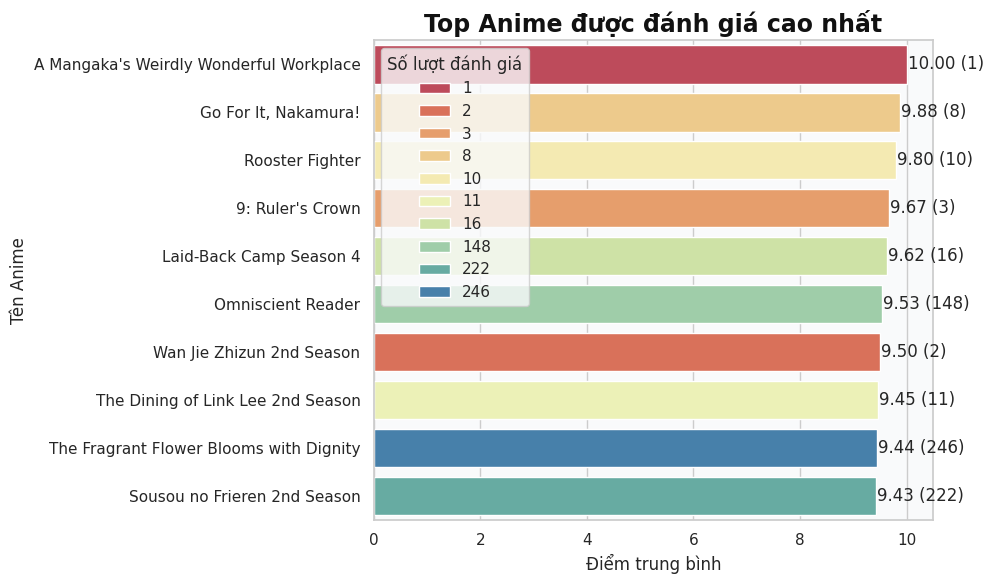

In [13]:
animes_best_rates = best_rated(animes_rating)

In [ ]:
animes_best_rates.repartition(1).write.format('parquet').mode("overwrite").save('../output/parquet/animes_best_rated/')
animes_best_rates.repartition(1).write.format('csv').mode("overwrite").save('../output/csv/animes_best_rated/')

In [14]:
# names = [
#         "Haru", "Yuki", "Rin", "Akira", "Sora", "Kaito", "Mika", "Aoi", "Ren", "Rei",
#         "Minh", "Hải", "An", "Linh", "Nam", "Hà", "Tú", "Trang", "Phong", "Vy",
#         "Alex", "Mina", "Leo", "Emma", "Kenji", "Sana", "Riko", "Noa", "Hana", "Taro"
#     ]


# user_df = animes_rating.select("userID").distinct() \
#                         .withColumn('rand_index' , floor(F.rand() * len(names)))

# name_df = spark.createDataFrame([(n,) for n in names] , ['user_name']) \
#                 .withColumn('rand_index' , floor(F.rand() * len(names)))
# user = user_df.join(name_df , 'rand_index' , 'inner').select('userID' , 'user_name')
# most_watch = animes_rating.join(broadcast(user) , 'userID' , 'inner')
# genres_array = most_watch.withColumn('genres_array' , F.from_json(F.col('genres') , ArrayType(StringType())))
# # Explode cột genres
# genres_explode = genres_array.withColumn('genres' , F.explode('genres_array'))
# genres_explode = genres_explode.select('userID'  , 'user_name' , 'type' , 'year' , 'rating' , 'genres')

# 2. Số lượt đánh giá các kiểu phim của từng user trong từng năm

In [175]:
def explode_outer(animes_rating) :    
    
    # Chuyển đổi kiểu dữ liệu của cột genres từ String thành Array
    genres_array = animes_rating.withColumn('genres_array' , F.from_json(F.col('genres') , ArrayType(StringType())))
    # Explode cột genres
    genres_explode = genres_array.withColumn('genres' , F.explode('genres_array'))
    genres_explode = genres_explode.select('userID'  , 'type' , 'year' , 'rating' , 'genres')
    return genres_explode

In [176]:
def type_per_year(animes_rating) :
    type_anime = explode_outer(animes_rating)
    type_anime = type_anime.drop( 'genres')
    # Pivot table
    type_anime_pivot = type_anime.groupBy( 'userID' ,'year' ).pivot('type').agg(F.count('rating'))
    # Sắp xếp theo từng userid theo từng năm
    type_anime_sort = type_anime_pivot.orderBy('userID', 'year' )
    spark.catalog.clearCache()
    return type_anime_sort

In [177]:
# Lấy ra loại phim có số lượt đánh nhiều nhất của user
def most_watch(type_anime) : 
    column = [c  for c in type_anime.columns if (c != 'userID') & (c != 'year') ]
    type_anime= type_anime.withColumn('most_watch' , F.array_max(
                                                            F.array(
                                                               *[
                                                                    struct(lit(c).alias('name')  , col(c).alias('value')) for c in column
                                                                ]
                                                            )
                                                        )
                                                    )
    most_watch = type_anime.withColumn('most_watch' , col('most_watch.name')) 
    return most_watch

In [178]:
# Lấy ra các thể loại phim mà user hay xem
def user_type(type_anime) :
    column = [c  for c in type_anime.columns if (c != 'userID') & (c != 'year') ]
    user_type = type_anime.withColumn('type_user' , 
                                        concat_ws('-' , 
                                        *[when(col(c).isNotNull() , lit(c)).otherwise(lit(None)) for c in column]))
    return user_type

In [179]:
def type_anime(animes_rating) :
    type_anime = type_per_year(animes_rating)
    most_watch_user = most_watch(type_anime)
    result = user_type(most_watch_user)
    return result


In [180]:
type_anime = type_anime(animes_rating)

In [181]:
type_anime.show()

+------+----+-----+----+----+-------+----+----------+--------------------+
|userID|year|MOVIE| ONA| OVA|SPECIAL|  TV|most_watch|           type_user|
+------+----+-----+----+----+-------+----+----------+--------------------+
|     1|1986| NULL|NULL|NULL|   NULL|   4|        TV|       TV-most_watch|
|     1|1989|    5|NULL|NULL|   NULL|   4|        TV| MOVIE-TV-most_watch|
|     1|1990| NULL|NULL|NULL|      4|NULL|        TV|  SPECIAL-most_watch|
|     1|1992|    5|NULL|NULL|   NULL|   2|        TV| MOVIE-TV-most_watch|
|     1|1993|    5|NULL|NULL|      3|NULL|        TV|MOVIE-SPECIAL-mos...|
|     1|1995| NULL|NULL|NULL|   NULL|   3|        TV|       TV-most_watch|
|     1|1996| NULL|NULL|NULL|   NULL|   7|        TV|       TV-most_watch|
|     1|1997|    4|NULL|NULL|   NULL|   4|        TV| MOVIE-TV-most_watch|
|     1|1998|   10|NULL|NULL|   NULL|   9|        TV| MOVIE-TV-most_watch|
|     1|1999| NULL|NULL|   3|   NULL|  11|        TV|   OVA-TV-most_watch|
|     1|2000| NULL|NULL| 

In [182]:
type_anime.repartition(1).write.format('parquet').mode("overwrite").save('../output/parquet/type_per_year/')

# 3 . Trung bình đánh giá của người dùng theo từng thể loại

In [136]:
def genres_user(animes_rating) :
    genres_rated = explode_outer(animes_rating)
    genres_rated = genres_rated.select('userID' , 'genres' , 'rating')
    genres_rated = genres_rated.groupBy('userID' , 'genres') \
                            .agg(F.avg('rating').alias('avg_rating')) \
                            .orderBy(desc('avg_rating')).limit(100)
    genres_rated_vs = genres_rated.toPandas()
    genres_rated_vs = genres_rated_vs.pivot_table(index = "userID" , columns = "genres" , values = "avg_rating")
    genres_rated_vs
    plt.figure(figsize = (12,8))
    sns.heatmap(genres_rated_vs  , cmap = "YlGnBu" , linewidths = 0.5)
    plt.title("Số lượng đánh giá theo người dùng và thể loại")
    plt.xlabel('Thể loại')
    plt.ylabel('Mã người dùng')

    plt.tight_layout()
    plt.show()

    return genres_rated
    

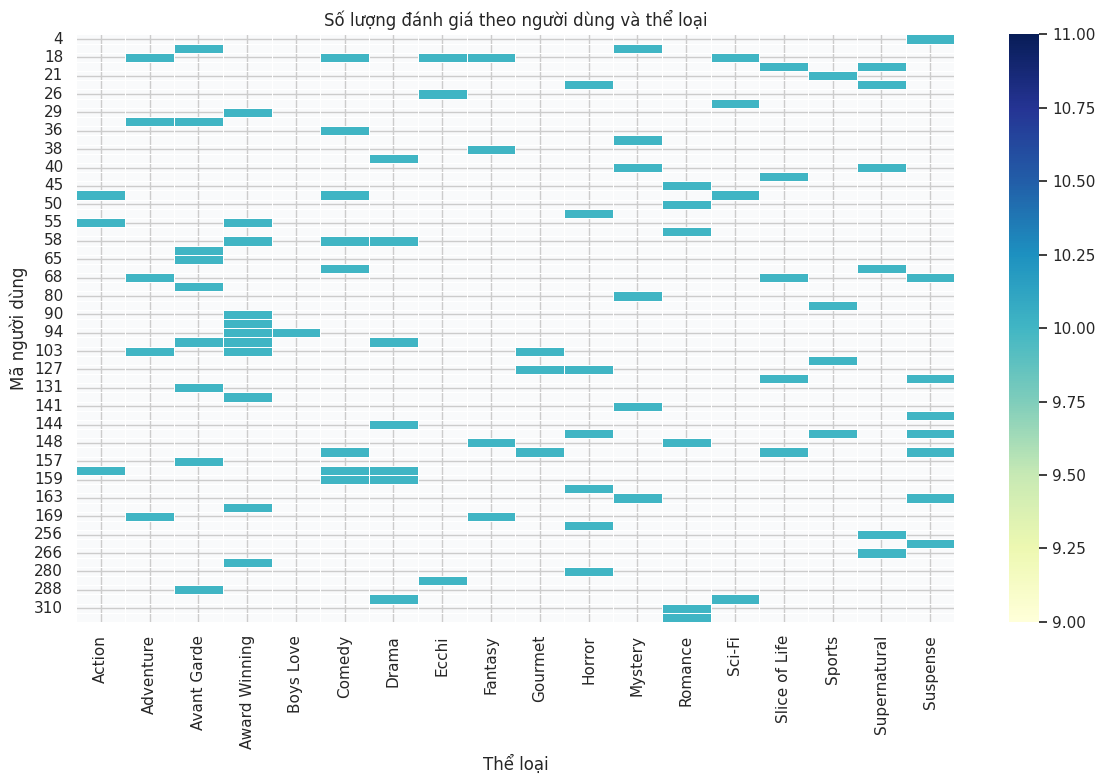

In [137]:
genres_user_write = genres_user(animes_rating)

In [140]:
genres_user_write.repartition(1).write.format('parquet').mode('overwrite').save("../output/parquet/genres_user/")

# So sánh định dạng csv , parquet , orc

In [68]:
print("="*90)
print("="*3+ "Load file csv" + "="*3)
print("="*90)


===Load file csv===


In [119]:
df = spark.read.csv('../data/ratings.csv' , header = True)

In [120]:
print(f"Số hàng : {df.count()} \nSố cột : {len(df.columns)}")

Số hàng : 148170496 
Số cột : 3


In [123]:
format = ['csv' , 'parquet' , 'orc']
write_time = []
read_time = []
sizes = []

In [124]:
# Ghi ra các định dạng và đo thời gian
for fm in format :
    output = f"/home/mhai/Project DE/EXAM_DATA/Week3/output/evaluate/{fm}/"
    
    start = time.time()
    if fm == 'csv' :
        df.write.format('csv').option('header' , True).mode("overwrite").save(output)
        num = 0
    if fm == 'parquet' :
        df.write.format('parquet').mode("overwrite").save(output)
        num = 1
    if fm == 'orc' :
        df.write.format('orc').mode("overwrite").save(output)
        num = 2
    write_time.append(builtins.round(time.time() - start , 2))

    size_byte = int(subprocess.check_output(['du' , '-sb' , output]).split()[0])
    sizes.append(builtins.round(size_byte / (1024*1024) , 2))
    print(f"Ghi file {fm.upper()} xong : {write_time[num]}s , {sizes[num]} MB ")

Ghi file CSV xong : 55.5s , 2024.76 MB 


Ghi file PARQUET xong : 54.71s , 323.98 MB 


Ghi file ORC xong : 95.97s , 268.69 MB 


In [125]:
# Đọc các định dạng 
for fm in format :
    output = f"../output/evaluate/{fm}/"

    start = time.time()

    if fm == 'csv' :
        spark.read.format('csv').option('header' , True).load(output)
        num = 0
    if fm == 'parquet' :
        spark.read.format('parquet').load(output)
        num = 1
    if fm == 'orc' :
        spark.read.format('orc').load(output)
        num = 2

    read_time.append(builtins.round(time.time() - start , 2))

    print(f"Đọc file {fm.upper()} trong : {read_time[num]}")



Đọc file CSV trong : 0.11
Đọc file PARQUET trong : 0.05
Đọc file ORC trong : 0.01


In [126]:
# Đưa ra biểu đồ so sánh

data = pd.DataFrame({
    "Format" : format ,
    "Write Time (s)" : write_time ,
    "Read Time (s)" : read_time ,
    "Sizes (MB)" : sizes
})

In [127]:
print("\n=== Kết quả tổng hợp ===")
data


=== Kết quả tổng hợp ===


,Format,Write Time (s),Read Time (s),Sizes (MB)
0,csv,55.50,0.11,2024.76
1,parquet,54.71,0.05,323.98
2,orc,95.97,0.01,268.69


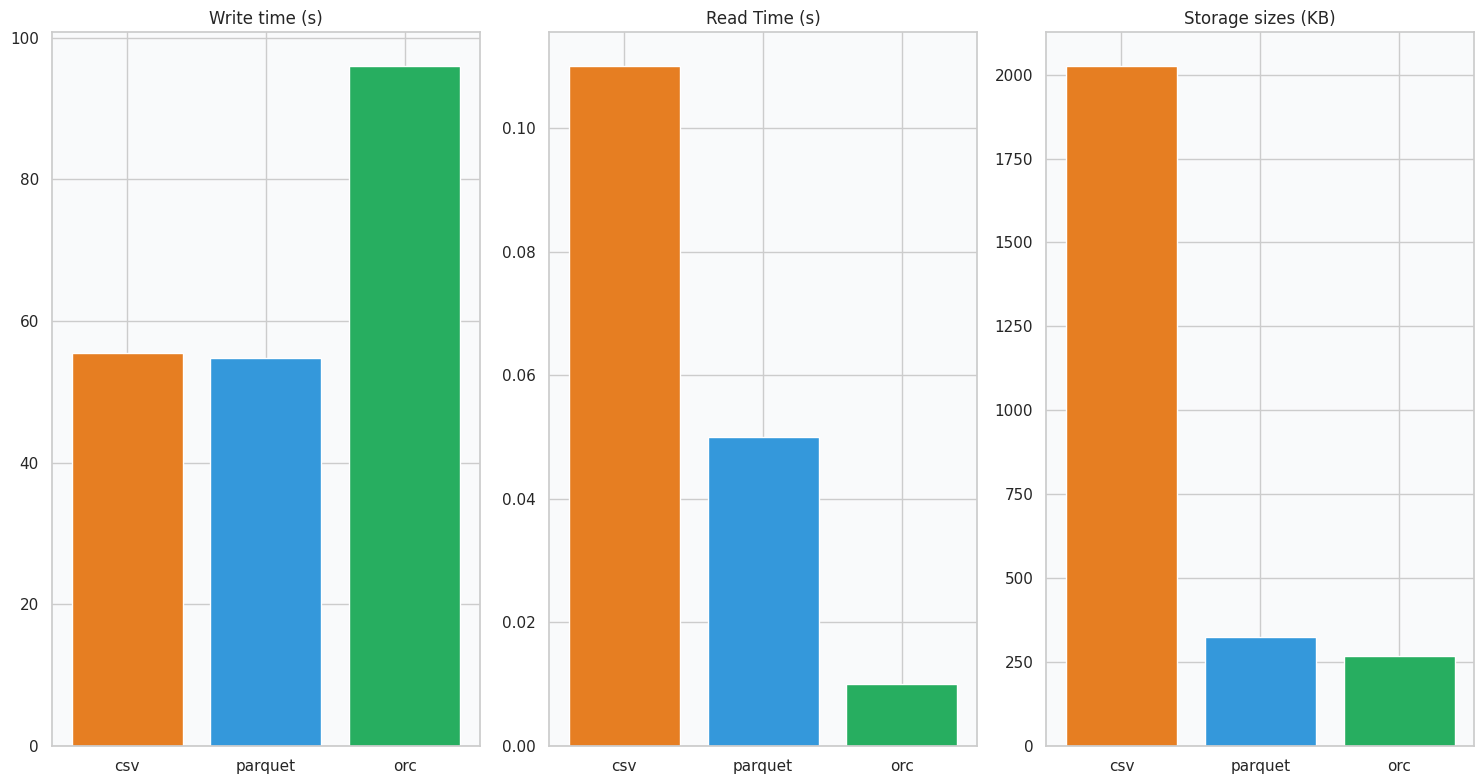

In [129]:
fig , axes = plt.subplots(1 , 3 , figsize = (15 , 8)) 
axes[0].bar(data['Format'] , data['Write Time (s)'] , color=["#e67e22", "#3498db", "#27ae60"]) 
axes[0].set_title('Write time (s)')

axes[1].bar(data['Format'] , data['Read Time (s)'] , color=["#e67e22", "#3498db", "#27ae60"]) 
axes[1].set_title('Read Time (s)')

axes[2].bar(data['Format'] , data['Sizes (MB)'] , color=["#e67e22", "#3498db", "#27ae60"]) 
axes[2].set_title('Storage sizes (KB)')

plt.tight_layout()
plt.show()

## => Kết luận CSV là chỉ dùng cho xử lý dữ liệu đơn giản không nên dùng với Big Data, parquet và orc vẫn nhanh hơn và lưu trữ tối ưu hơn